 <h1 style="color:brown;">Ship detection from Satellite images using VGG16 pre-trained model</h1>

In the following exercise, I will train an output layer over the pre-trained 2014 Image-Net winning VGG16 model. The objective of this exercise is to demonstrate the power of transfer learning, and how to use the VGG16 keras API call. The task at hand is binary classification on different 80x80 satellite images. We are to determine whether the image contains a ship or does not contain one.

Dataset at https://www.kaggle.com/rhammell/ships-in-satellite-imagery.

## Structure of the data

The data is downloaded as a zip file and is then split into. A positive set and a negative set. A simple mv grep command is used since the names of the files contains their label. We now have our home directory which contains two other directories, one for images missing boats, and one for images that contains them.

In [1]:
%matplotlib inline
# we set the data directory path
path = "/home/ubuntu/data/"
# we take a look at the directories
!echo "number of positives:" && ls "/home/ubuntu/data/train/boat_present" | wc -l 
!echo "number of negatives:" && ls "/home/ubuntu/data/train/boat_missing" | wc -l 
!echo "number of validation positives:" && ls "/home/ubuntu/data/validation/boat_present_validation" | wc -l 
!echo "number of validation negatives:" && ls "/home/ubuntu/data/validation/boat_missing_validation" | wc -l 

number of positives:
572
number of negatives:
1588
number of validation positives:
128
number of validation negatives:
512


So we have a total of 2800 samples, which is a somewhat small dataset.

## Training the model

To train the model, we first predict bottleneck features on a pre-trained VGG16 model so that we can then use those features to train the output layer we will add. 

First, let us import some useful libraries:

In [2]:
# widely-used array operation and manipulation library
import numpy as np 
# For preprocessing .png files
from keras.preprocessing.image import ImageDataGenerator 
# Building blocks for our top layer
from keras.models import Sequential, Model
from keras import optimizers
from keras.layers import Dropout, Flatten, Dense
# To import our VGG16 model
from keras import applications

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)


Initialize some useful variables:

In [3]:
# dimensions of our images
img_width, img_height = 80, 80

top_model_weights_path = 'bottleneck_features.h5'
train_data_dir = '/home/ubuntu/data/train'
validation_data_dir = '/home/ubuntu/data/validation'
#set number of training examples
nb_train_samples = 2160
nb_validation_samples = 640
#set number of epochs
epochs = 10
#set batch size
batch_size = 16


We then create .npy files of every input image using the ImageDataGenerator:

In [4]:
def save_bottleneck_features():
    datagen = ImageDataGenerator(rescale=1. / 255)
    # build the VGG16 network with custom input_shape
    model = applications.VGG16(include_top=False, weights='imagenet', input_shape=(80,80,3))

    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        shuffle=False) # we do not want to shuffle here since labels are going to be added afterwards
    bottleneck_features_train = model.predict_generator(
        generator, nb_train_samples // batch_size)
    np.save(open('bottleneck_features.npy', 'w'),
            bottleneck_features_train)
    
    generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        shuffle=False) # we do not want to shuffle here since labels are going to be added afterwards
    bottleneck_features_validation = model.predict_generator(
        generator, nb_validation_samples // batch_size)
    np.save(open('bottleneck_features_validation.npy', 'w'),
            bottleneck_features_validation)
    

In [5]:
def train_top_model():
    train_data = np.load(open('bottleneck_features.npy'))
    train_labels = np.array(
        [0] * (1588) + [1] * (572))
    
    validation_data = np.load(open('bottleneck_features_validation.npy'))
    validation_labels = np.array(
        [0] * (512) + [1] *(128))
    
    #create our top layer and train it
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy', metrics=['accuracy'])

    model.fit(train_data, train_labels,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(validation_data, validation_labels), shuffle=True)
    model.save_weights(top_model_weights_path)
    

In [6]:
# we call both functions
save_bottleneck_features()
train_top_model()

Found 2160 images belonging to 2 classes.
Found 640 images belonging to 2 classes.
Train on 2160 samples, validate on 640 samples
Epoch 1/10
2160/2160 [==============================] - 0s 230us/step - loss: 0.1973 - acc: 0.9185 - val_loss: 0.0447 - val_acc: 0.9859
Epoch 2/10
2160/2160 [==============================] - 1s 240us/step - loss: 0.1235 - acc: 0.9606 - val_loss: 0.0762 - val_acc: 0.9766
Epoch 3/10
2160/2160 [==============================] - 1s 241us/step - loss: 0.0838 - acc: 0.9750 - val_loss: 0.0488 - val_acc: 0.9797
Epoch 4/10
2160/2160 [==============================] - 1s 243us/step - loss: 0.0825 - acc: 0.9778 - val_loss: 0.0804 - val_acc: 0.9750
Epoch 5/10
2160/2160 [==============================] - 1s 243us/step - loss: 0.0710 - acc: 0.9782 - val_loss: 0.0939 - val_acc: 0.9781
Epoch 6/10
2160/2160 [==============================] - 1s 245us/step - loss: 0.0627 - acc: 0.9843 - val_loss: 0.0597 - val_acc: 0.9828
Epoch 7/10
2160/2160 [==============================] 

Here we see that our model achieves around 97-98% accuracy on our validation set. That is not too bad for just training a fully connected layer on top of the pre-trained VGG16 model. Now we need to connect the new top layer and the chopped off VGG16 model. As we will see, it is very straightforward. We first create the same VGG16 base model that was used when predicting the bottleneck features, then do the same for our fully-connected layer.

In [7]:
base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(80,80,3))
print('Model loaded.')

Model loaded.


In [8]:
# we recreate our top layer with the already trained weights:
top_model = Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
top_model.add(Dense(512, activation='relu'))
#top_model.add(Dropout(0.5))
top_model.add(Dense(128, activation='relu'))
#top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid'))
top_model.load_weights(top_model_weights_path)


We freeze the layers up most of the VGG16 layers, so that we can fine tune our model without retraining the pre-trained weights.

In [9]:
for layer in base_model.layers[:14]:
    layer.trainable = False
# the add method does not work anymore as of Keras 2.0.6
model = Model(inputs= base_model.input, outputs= top_model(base_model.output))

In [10]:

# add in data augmentation to deal with small set
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True) 

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')


model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

# fine-tune the model
model.fit_generator(
    train_generator,
    samples_per_epoch=nb_train_samples,
    epochs=epochs,
    validation_data=validation_generator,
    shuffle=True)

Found 2160 images belonging to 2 classes.
Found 640 images belonging to 2 classes.


/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:34: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., epochs=10, steps_per_epoch=135, validation_data=<keras.pre..., shuffle=True)`


Epoch 1/10
135/135 [==============================] - 16s 119ms/step - loss: 0.1005 - acc: 0.9741 - val_loss: 0.0944 - val_acc: 0.9781
Epoch 2/10
135/135 [==============================] - 16s 118ms/step - loss: 0.0401 - acc: 0.9898 - val_loss: 0.0690 - val_acc: 0.9859
Epoch 3/10
135/135 [==============================] - 16s 118ms/step - loss: 0.0209 - acc: 0.9954 - val_loss: 0.0915 - val_acc: 0.9812
Epoch 4/10
135/135 [==============================] - 16s 118ms/step - loss: 0.0192 - acc: 0.9917 - val_loss: 0.1335 - val_acc: 0.9734
Epoch 5/10
135/135 [==============================] - 16s 118ms/step - loss: 0.0224 - acc: 0.9926 - val_loss: 0.1163 - val_acc: 0.9766
Epoch 6/10
135/135 [==============================] - 16s 118ms/step - loss: 0.0151 - acc: 0.9935 - val_loss: 0.1002 - val_acc: 0.9859
Epoch 7/10
135/135 [==============================] - 16s 118ms/step - loss: 0.0113 - acc: 0.9958 - val_loss: 0.1388 - val_acc: 0.9766
Epoch 8/10
135/135 [==============================] - 1

It seems our train accuracy is slightly better than before. Fine tuning seems to work on the train set, but doesn't generalize because of the small amount of data that we have. Usually the fine tuning step would be run just once because of its slow gradient, but I deemed it appropriate run through ten more epochs to confirm an improvement.

Now lets look at some predictions.

In [11]:
from keras.preprocessing import image
def get_batches(dirname, gen=image.ImageDataGenerator(), shuffle=True, 
                batch_size=batch_size, class_mode='categorical'):
    return gen.flow_from_directory(path+dirname, target_size=(80,80), 
                class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

batches = get_batches("validation/", batch_size=5)

Found 640 images belonging to 2 classes.


In [12]:
import matplotlib.pyplot as plt
def grid_display_predictions(list_of_images, list_of_titles=[], no_of_columns=2, figsize=(7,7)):

    fig = plt.figure(figsize=figsize)
    column = 0
    for i in range(len(list_of_images)):
        column += 1
        #  check for end of column and create a new figure
        if column == no_of_columns+1:
            fig = plt.figure(figsize=figsize)
            column = 1
        fig.add_subplot(1, no_of_columns, column)
        plt.imshow(list_of_images[i])
        plt.axis('off')
        if len(list_of_titles) >= len(list_of_images):
            plt.title(list_of_titles[i])

In [13]:
imgs, labels = next(batches)

[ 1.  0.]
[ 1.  0.]
[ 1.  0.]
[ 1.  0.]
[ 0.  1.]


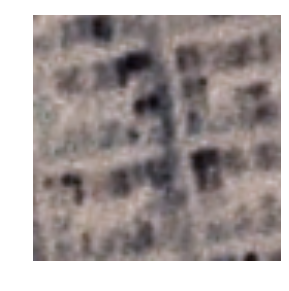

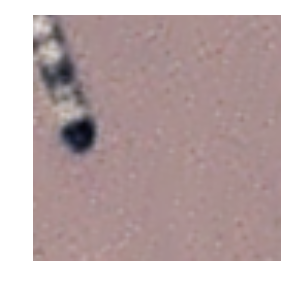

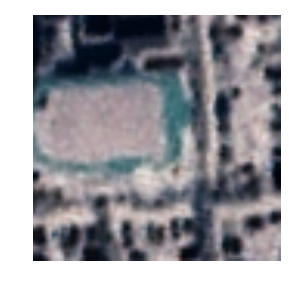

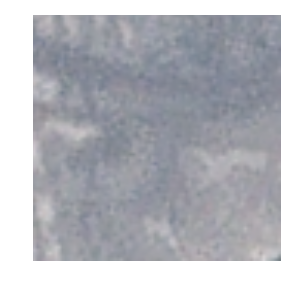

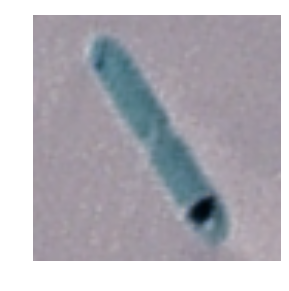

In [14]:
for i, img in enumerate(imgs):
    print labels[i]
    model.predict(np.asarray([img]))
    grid_display_predictions([img])

The model seems to handle predictions well. The set actually only contains ships that are seen completely. So the second image was classified right since a portion of it was missing.